## Imports

In [1]:
import requests

from utils import *

## US states & counties

In [2]:
# url = 'https://www2.census.gov/geo/tiger/TIGER2020/STATE/tl_2020_us_state.zip'
# states = (gpd.read_file(url).rename(columns=str.lower).to_crs(CRS_DEG)
#           [['geoid', 'name', 'region', 'division', 'geometry']]
#           .sort_values('geoid').reset_index(drop=1)).disp()
# states.to_parquet('data/states.parquet') # 4s
states = gpd.read_parquet('data/states.parquet').disp()

56 rows x 5 cols; Memory: 0.0 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,name,region,division,geometry
,<object>,<object>,<object>,<object>,<geometry>
0,01,Alabama,3,6,"POLYGON ((-88.139988 34.581703, -88.139969 34...."


In [3]:
# url = 'https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip'
# counties = (gpd.read_file(url)[['GEOID', 'NAME']]
#             .rename(columns=D(GEOID='geoid', NAME='county'))).disp()
# counties.to_parquet('data/counties.parquet') # 14s
counties = pd.read_parquet('data/counties.parquet').disp()

3,234 rows x 2 cols; Memory: 0.4 MiB


,geoid,county
,<object>,<object>
0,31039,Cuming


## Population
Download the population and labor force size of each census block group and tract from the American Community Survey dataset.

In [4]:
# popu_cols = D(B01001_001E='popu', B23025_002E='labor')
# bg_popu = []
# # download the population stats for the 50 US states + DC
# for state in tqdm(states.geoid.head(51)):
#     url = ('https://api.census.gov/data/2020/acs/acs5?' +
#            'get=' + ','.join(popu_cols) + '&for=block+group:*' +
#            f'&in=state:{state}+county:*+tract:*')
#     data = requests.get(url).json()
#     df = Pdf(data[1:], columns=data[0])
#     df.insert(0, 'geoid', df.pop('state') + df.pop('county') + 
#               df.pop('tract') + df.pop('block group'))
#     bg_popu.append(df.rename(columns=popu_cols))
# bg_popu = pd.concat(bg_popu).astype(D(popu=I32, labor=I32)).disp()
# bg_popu.to_parquet('data/bg_population.parquet') # 1m31s
bg_popu = pd.read_parquet('data/bg_population.parquet').disp()

239,780 rows x 3 cols; Memory: 19.4 MiB


,geoid,popu,labor
,<object>,<int32>,<int32>
0,010610503006,758,297


## Urban areas
Download the constituent census blocks of urban areas as defined by the Census Bureau in 2020. Then, identify the corresponding block groups and tracts which contain at least one block in each urban area.

In [5]:
# url = 'https://www2.census.gov/geo/docs/reference/ua/2020_UA_BLOCKS.txt'
# cols = {'GEOID': 'geoid', '2020_UA_NAME': 'name', '2020_UACE': 'code'}
# df = pd.read_csv(url, sep='|', encoding_errors='replace', usecols=list(cols))
# df.rename(columns=cols, inplace=True)
# df.code = df.code.astype(str).str.zfill(5)
# df.geoid = df.geoid.astype(str).str.zfill(15)
# urba = []
# for level, nchar in [('County', 5), ('Tract', 11), ('BG', 12)]:
#     df2 = df.assign(geoid=df.geoid.str[:nchar])
#     df2 = df2.groupby(['code', 'name', 'geoid']).size()
#     df2 = df2.rename('n').reset_index().sort_values('n', ascending=0)
#     df2 = df2.drop_duplicates('geoid').sort_values('geoid')
#     urba.append(df2.assign(level=level))
# urba = pd.concat(urba).reset_index(drop=1)
# urba['city'] = [x.split(',')[0].split('-')[0].split('/')[0] for x in urba.name]
# urba = urba[['code', 'name', 'city', 'level', 'geoid']].astype(
#     {x: 'category' for x in ['level', 'name', 'code', 'city']})
# urba.to_parquet('data/urban_zones.parquet') # 18s
urba = pd.read_parquet('data/urban_zones.parquet').disp()

275,549 rows x 5 cols; Memory: 20.6 MiB


,code,name,city,level,geoid
,<category>,<category>,<category>,<category>,<object>
0,58600,"Montgomery, AL",Montgomery,County,01001


## 50 largest cities
Select the 50 most populous urban areas using the tract-level population.

In [16]:
top50 = Arr(urba.merge(bg_popu, on='geoid').groupby('city', observed=False)
            ['popu'].sum().sort_values(ascending=0).head(50).index); top50

array(['New York', 'Los Angeles', 'Chicago', 'Miami', 'Houston', 'Dallas',
       'Philadelphia', 'Washington', 'Atlanta', 'Boston', 'Phoenix',
       'Detroit', 'Seattle', 'San Francisco', 'San Diego', 'Minneapolis',
       'Tampa', 'Denver', 'Portland', 'Riverside', 'Baltimore',
       'St. Louis', 'Las Vegas', 'San Antonio', 'Columbus', 'Sacramento',
       'Austin', 'San Jose', 'Cleveland', 'Orlando', 'Pittsburgh',
       'Cincinnati', 'Indianapolis', 'Kansas City', 'Virginia Beach',
       'Charlotte', 'Jacksonville', 'Milwaukee', 'Providence', 'Richmond',
       'Nashville', 'Salt Lake City', 'Raleigh', 'Memphis', 'Hartford',
       'Springfield', 'Oklahoma City', 'Louisville', 'Buffalo',
       'Bridgeport'], dtype=object)

In [28]:
urba['top50'] = urba.city.isin(top50)
top50_bg = urba.query('top50').merge(bg_popu)[['geoid', 'popu', 'labor']].disp()

107,443 rows x 3 cols; Memory: 7.9 MiB


,geoid,popu,labor
,<object>,<int32>,<int32>
0,010810419012,1285,422


## Zones
Download the shapefile of the block groups and tracts which lie in the largest urban areas. Remove the zones with no land area for better plotting.

In [33]:
uri = 'https://www2.census.gov/geo/tiger/TIGER2020/BG'
zones = []
# for each state which includes at least one major urban area
for state in tqdm(set(urba.query('top50').geoid.str[:2])):
    bg = gpd.read_file(f'{uri}/tl_2020_{state}_bg.zip')
    bg = bg.to_crs(CRS_DEG).rename(columns=str.lower)
    bg = bg.merge(top50_bg, on='geoid').set_index('geoid')
    for x in ['aland', 'awater']: # convert area from sq.m. to sq.mi.
        bg[x] = (bg[x] * SQM2SQMI).astype(F32)
    bg = bg['aland awater popu labor geometry'.split()]
    bg = bg[bg['aland'] > 0] # remove water-only zones
    tract = bg.set_index(bg.index.str[:11]).dissolve('geoid', aggfunc='sum')
    county = tract.set_index(tract.index.str[:5]).dissolve('geoid', aggfunc='sum')
    zones += [df.assign(level=level) for level, df in D(
        BG=bg, Tract=tract, County=county).items()]
zones = pd.concat(zones).merge(urba[['geoid', 'city']], on='geoid')
zones['county_id'] = zones.geoid.str[:5]
zones = (zones.merge(counties.rename(columns=D(geoid='county_id')))
         ['geoid level county city aland awater popu labor geometry'.split()]
         .astype(D(city=CAT, county=CAT, level=CAT))).disp()
zones.to_parquet('data/zones.parquet') # 11m0s
# zones = gpd.read_parquet('data/zones.parquet').disp()

  0%|          | 0/43 [00:00<?, ?it/s]

## Fig: City map

<Axes: >

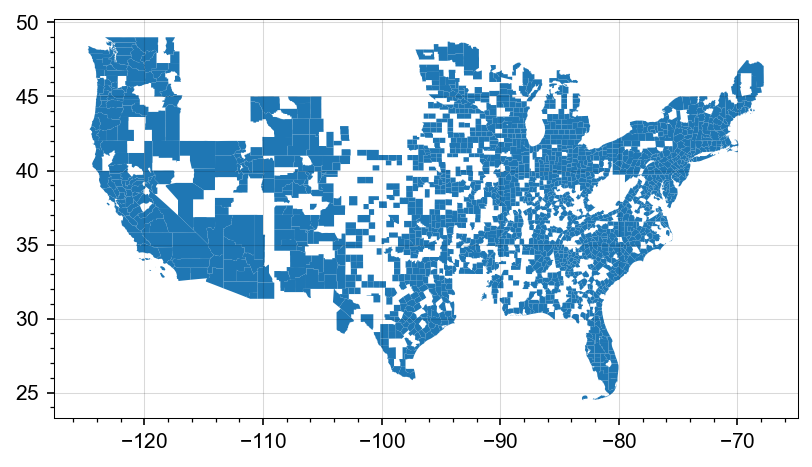

In [11]:
filt(zones, level='County').plot()

In [ ]:
ax = U.plot(size=(16, 8), dpi=250, axoff=1)
U.filt(zones, scale='County').plot(ax=ax, fc='yellow', ec='r', lw=0.2)
cities.plot(ax=ax, color='tomato', alpha=1)
states.plot(ax=ax, fc='none', ec='k', lw=0.25)
ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.MapBox, alpha=0.6)
for _, r in cities.iterrows():
    ax.text(*r.geometry.centroid.coords[0], str(r['rank']),
            ha='center', va='center', fontsize=9, color='w',
            bbox=D(boxstyle='circle', pad=0.1, fc='k', alpha=0.6))
U.imsave('Study region - 50 largest MSAs') # 14s